In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('laptop_data_train.csv')
df.head()

,Number,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


DATA PREPROCESSING

In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

Number              0
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

In [6]:
df.head()

,Number,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [7]:
df['Ram'] = df['Ram'].str.replace('GB', '')
df['Weight'] = df['Weight'].str.replace('kg', '')

In [8]:
df['Ram'] = df['Ram'].astype('int32')
df['Weight'] = df['Weight'].astype('float32')

In [9]:
# Split the 'ScreenResolution' column by 'x' and expand it into separate columns
resolution_split = df['ScreenResolution'].str.split('x', expand=True)

# Extract screen resolution width and height from the split columns
df['ResolutionWidth'] = resolution_split[0].str.extract('(\d+)').astype(int)
df['ResolutionHeight'] = resolution_split[1].str.extract('(\d+)').astype(int)

df.drop('ScreenResolution', axis=1, inplace=True)

In [10]:
import re

def extract_storage(memory_str):
    storage_parts = re.findall(r'(\d+)(GB|TB)', memory_str)
    total_storage = 0
    for part in storage_parts:
        size, unit = part
        size = int(size)
        if unit == 'TB':  # Convert TB to GB
            size *= 1024
        total_storage += size
    return total_storage

df['TotalStorageGB'] = df['Memory'].apply(extract_storage)

def primary_storage_type(memory_str):
    if 'SSD' in memory_str:
        return 'SSD'
    elif 'HDD' in memory_str:
        return 'HDD'
    elif 'Flash Storage' in memory_str:
        return 'Flash'
    else:
        return 'Other'

df['PrimaryStorageType'] = df['Memory'].apply(primary_storage_type)


In [11]:
def parse_general_cpu_type(cpu_str):
    
    match = re.search(r'(\bIntel\b|\bAMD\b)\s+(Core i\d|Celeron|Pentium|Xeon|A\d|Ryzen)', cpu_str)
    if match:
        brand = match.group(1)
        type = match.group(2).strip()
        # Safely extract the speed, ensuring the regex match is not None
        speed_match = re.search(r'(\d\.\d)GHz', cpu_str)
        if speed_match:
            speed_ghz = float(speed_match.group(1))
            return brand, type, speed_ghz
    return 'Unknown', 'Unknown', 0

# Apply the function again to simplify CPU types
df['CpuBrand'], df['CpuType'], df['CpuSpeedGHz'] = zip(*df['Cpu'].apply(parse_general_cpu_type))

# Create simplified CPU type dummies multiplied by the CPU speed
cpu_type_simplified_dummies = pd.get_dummies(df['CpuType'])
for column in cpu_type_simplified_dummies.columns:
    cpu_type_simplified_dummies[column] *= df['CpuSpeedGHz']

# Add these new features to the original DataFrame
data_with_simplified_cpu_speeds = pd.concat([df, cpu_type_simplified_dummies], axis=1)

# Show the first few rows to check the new structure with simplified CPU type and speed columns
data_with_simplified_cpu_speeds[['Cpu', 'CpuBrand', 'CpuType', 'CpuSpeedGHz']].head()


,Cpu,CpuBrand,CpuType,CpuSpeedGHz
0,Intel Core i5 2.3GHz,Intel,Core i5,2.3
1,Intel Core i5 1.8GHz,Intel,Core i5,1.8
2,Intel Core i5 7200U 2.5GHz,Intel,Core i5,2.5
3,Intel Core i7 2.7GHz,Intel,Core i7,2.7
4,Intel Core i5 3.1GHz,Intel,Core i5,3.1


In [12]:
# Create dummy variables for each CPU type, multiplied by the CPU speed
cpu_type_dummies = pd.get_dummies(df['CpuType'])
for column in cpu_type_dummies.columns:
    cpu_type_dummies[column] *= df['CpuSpeedGHz']

# Add these new features to the original DataFrame
data_with_cpu_speeds = pd.concat([df, cpu_type_dummies], axis=1)

# Show the first few rows to check the new structure with CPU type and speed columns
data_with_cpu_speeds.head()


,Number,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,A8,A9,Celeron,Core i3,Core i5,Core i7,Pentium,Ryzen,Unknown,Xeon
0,0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,...,0.0,0.0,0.0,0.0,2.3,0.0,0.0,0.0,0.0,0.0
1,1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,...,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0
2,2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
3,3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,...,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0
4,4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,...,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.0


In [13]:
def parse_gpu(gpu_str):
    # Extract GPU brand
    if "Nvidia" in gpu_str:
        brand = "Nvidia"
    elif "AMD" in gpu_str:
        brand = "AMD"
    elif "Intel" in gpu_str:
        brand = "Intel"
    else:
        brand = "Other"

    e
    model_match = re.search(r'(GeForce GTX|GeForce GT|Quadro|FirePro|Iris|HD Graphics|UHD Graphics|Radeon)', gpu_str)
    model = model_match.group(1) if model_match else "Unknown"

    return brand, model


df[['GpuBrand', 'GpuModel']] = df['Gpu'].apply(lambda x: pd.Series(parse_gpu(x)))

# Check the results
gpu_features_head = df[['Gpu', 'GpuBrand', 'GpuModel']].head()
gpu_features_head


,Gpu,GpuBrand,GpuModel
0,Intel Iris Plus Graphics 640,Intel,Iris
1,Intel HD Graphics 6000,Intel,HD Graphics
2,Intel HD Graphics 620,Intel,HD Graphics
3,AMD Radeon Pro 455,AMD,Radeon
4,Intel Iris Plus Graphics 650,Intel,Iris


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              901 non-null    int64  
 1   Company             901 non-null    object 
 2   TypeName            901 non-null    object 
 3   Inches              901 non-null    float64
 4   Cpu                 901 non-null    object 
 5   Ram                 901 non-null    int32  
 6   Memory              901 non-null    object 
 7   Gpu                 901 non-null    object 
 8   OpSys               901 non-null    object 
 9   Weight              901 non-null    float32
 10  Price               901 non-null    float64
 11  ResolutionWidth     901 non-null    int64  
 12  ResolutionHeight    901 non-null    int64  
 13  TotalStorageGB      901 non-null    int64  
 14  PrimaryStorageType  901 non-null    object 
 15  CpuBrand            901 non-null    object 
 16  CpuType 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


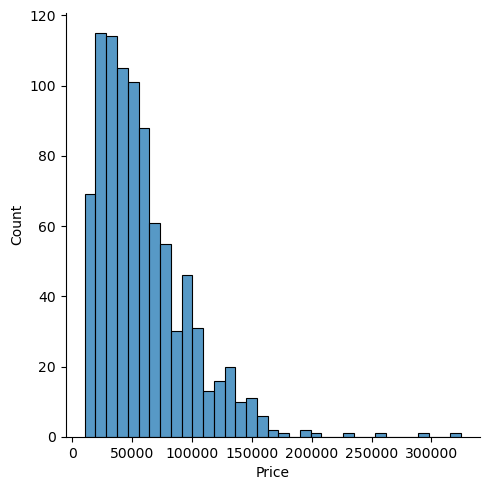

In [15]:
sns.displot(df['Price'])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


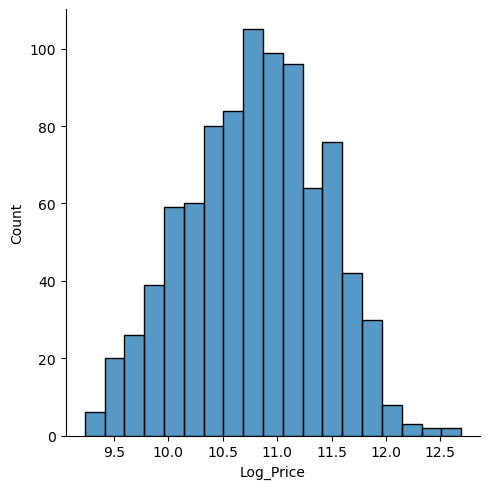

In [16]:
df['Log_Price'] = np.log(df['Price'])
sns.displot(df['Log_Price'])

In [17]:
X_train = df.drop(['Price', 'Number', 'Log_Price'], axis=1)  # Drop 'Price' which is the target and 'Number' which is just an index
y_train = df['Log_Price']

In [18]:
X_train.head()

,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,ResolutionWidth,ResolutionHeight,TotalStorageGB,PrimaryStorageType,CpuBrand,CpuType,CpuSpeedGHz,GpuBrand,GpuModel
0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,2560,1600,128,SSD,Intel,Core i5,2.3,Intel,Iris
1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,1440,900,128,Flash,Intel,Core i5,1.8,Intel,HD Graphics
2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,1920,1080,256,SSD,Intel,Core i5,2.5,Intel,HD Graphics
3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2880,1800,512,SSD,Intel,Core i7,2.7,AMD,Radeon
4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,2560,1600,256,SSD,Intel,Core i5,3.1,Intel,Iris


In [19]:
y_train.head()

0    11.175755
1    10.776777
2    10.329931
3    11.814476
4    11.473101
Name: Log_Price, dtype: float64

In [20]:
df.head()

,Number,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,ResolutionWidth,ResolutionHeight,TotalStorageGB,PrimaryStorageType,CpuBrand,CpuType,CpuSpeedGHz,GpuBrand,GpuModel,Log_Price
0,0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,...,2560,1600,128,SSD,Intel,Core i5,2.3,Intel,Iris,11.175755
1,1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,...,1440,900,128,Flash,Intel,Core i5,1.8,Intel,HD Graphics,10.776777
2,2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,...,1920,1080,256,SSD,Intel,Core i5,2.5,Intel,HD Graphics,10.329931
3,3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,...,2880,1800,512,SSD,Intel,Core i7,2.7,AMD,Radeon,11.814476
4,4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,...,2560,1600,256,SSD,Intel,Core i5,3.1,Intel,Iris,11.473101


In [21]:
# Load the test dataset as well to ensure similar preprocessing
test_data_path = 'laptop_data_test.csv'
test_data = pd.read_csv(test_data_path)

# Feature engineering already done on 'data' needs to be applied to 'test_data' too
test_data['Ram'] = test_data['Ram'].str.replace('GB', '').astype('int32')
test_data['Weight'] = test_data['Weight'].str.replace('kg', '').astype('float32')
resolution_split_test = test_data['ScreenResolution'].str.split('x', expand=True)
test_data['ResolutionWidth'] = resolution_split_test[0].str.extract('(\d+)').astype(int)
test_data['ResolutionHeight'] = resolution_split_test[1].str.extract('(\d+)').astype(int)
test_data.drop('ScreenResolution', axis=1, inplace=True)
test_data['Log_Price'] = np.log(test_data['Price'])
X_test = test_data.drop(['Price', 'Number', 'Log_Price'], axis=1)  # Drop 'Price' which is the target and 'Number' which is just an index
y_test = test_data['Log_Price']


In [22]:
def extract_storage(memory_str):
    storage_parts = re.findall(r'(\d+)(GB|TB)', memory_str)
    total_storage = 0
    for part in storage_parts:
        size, unit = part
        size = int(size)
        if unit == 'TB':  # Convert TB to GB
            size *= 1024
        total_storage += size
    return total_storage

# Apply the function to create a new column
test_data['TotalStorageGB'] = test_data['Memory'].apply(extract_storage)

def primary_storage_type(memory_str):
    if 'SSD' in memory_str:
        return 'SSD'
    elif 'HDD' in memory_str:
        return 'HDD'
    elif 'Flash Storage' in memory_str:
        return 'Flash'
    else:
        return 'Other'

test_data['PrimaryStorageType'] = test_data['Memory'].apply(primary_storage_type)

In [23]:
def parse_general_cpu_type(cpu_str):
    # Extract general CPU brand and type
    match = re.search(r'(\bIntel\b|\bAMD\b)\s+(Core i\d|Celeron|Pentium|Xeon|A\d|Ryzen)', cpu_str)
    if match:
        brand = match.group(1)
        type = match.group(2).strip()
       
        speed_match = re.search(r'(\d\.\d)GHz', cpu_str)
        if speed_match:
            speed_ghz = float(speed_match.group(1))
            return brand, type, speed_ghz
    return 'Unknown', 'Unknown', 0

#  simplify CPU types
test_data['CpuBrand'], test_data['CpuType'], test_data['CpuSpeedGHz'] = zip(*test_data['Cpu'].apply(parse_general_cpu_type))

# simplified CPU type dummies multiplied by the CPU speed
cpu_type_simplified_dummies = pd.get_dummies(test_data['CpuType'])
for column in cpu_type_simplified_dummies.columns:
    cpu_type_simplified_dummies[column] *= test_data['CpuSpeedGHz']

# Add these new features to the original DataFrame
data_with_simplified_cpu_speeds = pd.concat([test_data, cpu_type_simplified_dummies], axis=1)
data_with_simplified_cpu_speeds[['Cpu', 'CpuBrand', 'CpuType', 'CpuSpeedGHz']].head()

,Cpu,CpuBrand,CpuType,CpuSpeedGHz
0,Intel Core i7 6820HK 2.7GHz,Intel,Core i7,2.7
1,Intel Core i7 7Y75 1.3GHz,Intel,Core i7,1.3
2,Intel Core i7 7500U 2.7GHz,Intel,Core i7,2.7
3,Intel Core i5 7200U 2.5GHz,Intel,Core i5,2.5
4,Intel Core i7 7500U 2.7GHz,Intel,Core i7,2.7


In [24]:
def parse_gpu(gpu_str):
    # Extract GPU brand
    if "Nvidia" in gpu_str:
        brand = "Nvidia"
    elif "AMD" in gpu_str:
        brand = "AMD"
    elif "Intel" in gpu_str:
        brand = "Intel"
    else:
        brand = "Other"

    
    model_match = re.search(r'(GeForce GTX|GeForce GT|Quadro|FirePro|Iris|HD Graphics|UHD Graphics|Radeon)', gpu_str)
    model = model_match.group(1) if model_match else "Unknown"

    return brand, model


test_data[['GpuBrand', 'GpuModel']] = test_data['Gpu'].apply(lambda x: pd.Series(parse_gpu(x)))

# Check the results
gpu_features_head = test_data[['Gpu', 'GpuBrand', 'GpuModel']].head()
gpu_features_head

,Gpu,GpuBrand,GpuModel
0,Nvidia GeForce GTX 980M,Nvidia,GeForce GTX
1,Intel HD Graphics 615,Intel,HD Graphics
2,Intel HD Graphics 620,Intel,HD Graphics
3,Intel HD Graphics 620,Intel,HD Graphics
4,Intel HD Graphics 620,Intel,HD Graphics


In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              402 non-null    int64  
 1   Company             402 non-null    object 
 2   TypeName            402 non-null    object 
 3   Inches              402 non-null    float64
 4   Cpu                 402 non-null    object 
 5   Ram                 402 non-null    int32  
 6   Memory              402 non-null    object 
 7   Gpu                 402 non-null    object 
 8   OpSys               402 non-null    object 
 9   Weight              402 non-null    float32
 10  Price               402 non-null    float64
 11  ResolutionWidth     402 non-null    int64  
 12  ResolutionHeight    402 non-null    int64  
 13  Log_Price           402 non-null    float64
 14  TotalStorageGB      402 non-null    int64  
 15  PrimaryStorageType  402 non-null    object 
 16  CpuBrand

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              901 non-null    int64  
 1   Company             901 non-null    object 
 2   TypeName            901 non-null    object 
 3   Inches              901 non-null    float64
 4   Cpu                 901 non-null    object 
 5   Ram                 901 non-null    int32  
 6   Memory              901 non-null    object 
 7   Gpu                 901 non-null    object 
 8   OpSys               901 non-null    object 
 9   Weight              901 non-null    float32
 10  Price               901 non-null    float64
 11  ResolutionWidth     901 non-null    int64  
 12  ResolutionHeight    901 non-null    int64  
 13  TotalStorageGB      901 non-null    int64  
 14  PrimaryStorageType  901 non-null    object 
 15  CpuBrand            901 non-null    object 
 16  CpuType 

RANDOM FOREST

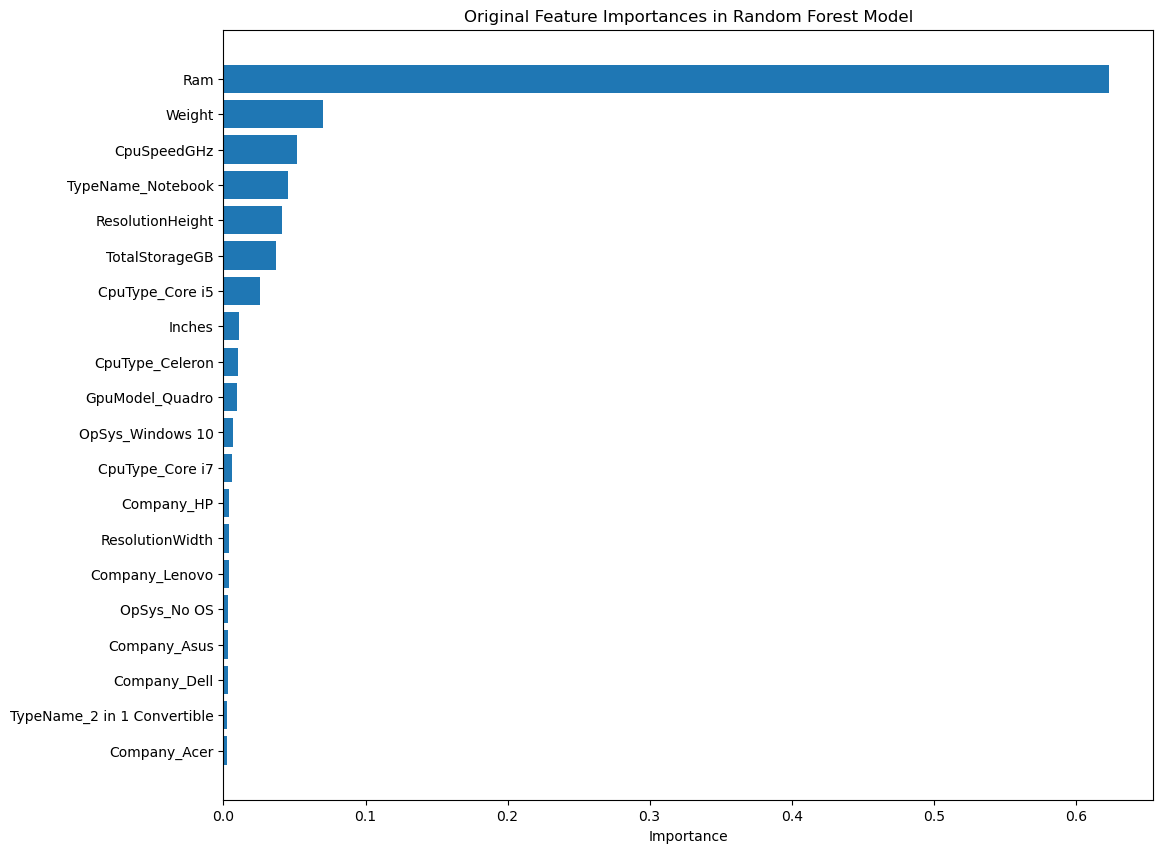

,Feature,Importance
1,Ram,0.623499
2,Weight,0.070246
6,CpuSpeedGHz,0.051449
29,TypeName_Notebook,0.045420
4,ResolutionHeight,0.041502
5,TotalStorageGB,0.036986
51,CpuType_Core i5,0.025787
0,Inches,0.011143
49,CpuType_Celeron,0.010213
65,GpuModel_Quadro,0.009514


In [27]:
# List of original and derived features to be included directly
original_features = [
    'Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'ResolutionWidth', 'ResolutionHeight',
    'TotalStorageGB', 'CpuBrand', 'CpuType', 'CpuSpeedGHz',  'GpuBrand', 'GpuModel']

# Create preprocessing for the original features
original_numerical_cols = ['Inches', 'Ram', 'Weight', 'ResolutionWidth', 'ResolutionHeight', 'TotalStorageGB', 'CpuSpeedGHz']
original_categorical_cols = ['Company', 'TypeName', 'OpSys', 'CpuBrand', 'CpuType', 'GpuBrand', 'GpuModel' ]


# Create preprocessing transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define transformers for the original feature set
original_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, original_numerical_cols),
        ('cat', categorical_transformer, original_categorical_cols)
    ])

# Create a Random Forest model pipeline using the original feature set
original_model = Pipeline(steps=[
    ('preprocessor', original_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model using the original features
original_X_train = df[original_features]
original_X_test = test_data[original_features]
original_model.fit(original_X_train, y_train)

# Extract feature importances from the original model
original_feature_importances = original_model.named_steps['regressor'].feature_importances_

# Get feature names from the original preprocessor step
original_all_features = (original_numerical_cols +
                         list(original_model.named_steps['preprocessor']
                              .named_transformers_['cat']
                              .named_steps['onehot']
                              .get_feature_names_out(original_categorical_cols)))

# Create a DataFrame to view the importances
original_importances_df = pd.DataFrame({
    'Feature': original_all_features,
    'Importance': original_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting the original feature importances
plt.figure(figsize=(12, 10))
plt.title('Original Feature Importances in Random Forest Model')
plt.barh(original_importances_df['Feature'][:20], original_importances_df['Importance'][:20])
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()

original_importances_df[:20]  # Show the top 20 most important original features

In [30]:
from sklearn.linear_model import LinearRegression

# Baseline Model with numerical data only

numerical_cols = [ 'Ram', 'Weight', 'ResolutionWidth', 'ResolutionHeight', 'TotalStorageGB', 'CpuSpeedGHz']

X_train = df[numerical_cols]
y_train = df['Log_Price']
X_test = test_data[numerical_cols]
y_test = test_data['Log_Price']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ])

# Create a Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('RMSE(Baseline)', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)

print('MAE(Baseline)', mae)
print('R-Squared(Baseline)',r2)

RMSE(Baseline) 0.4257124979645533
MAE(Baseline) 0.33473536192672987
R-Squared(Baseline) 0.5401498146869919


In [31]:
# Select features and target
features = [
    'Company', 'TypeName', 'Ram', 'OpSys', 'Weight', 'ResolutionWidth', 'ResolutionHeight',
    'TotalStorageGB', 'CpuBrand', 'CpuType', 'CpuSpeedGHz',  'GpuBrand', 'GpuModel']
X_train = df[features]
y_train = df['Log_Price']
X_test = test_data[features]
y_test = test_data['Log_Price']

# Preprocessing for numerical and categorical data
numerical_cols = [ 'Ram', 'Weight', 'ResolutionWidth', 'ResolutionHeight', 'TotalStorageGB', 'CpuSpeedGHz']
categorical_cols = ['Company', 'TypeName', 'OpSys', 'CpuBrand', 'CpuType', 'GpuBrand', 'GpuModel' ]

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('RMSE(RF)', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)

print('MAE(RF)', mae)
print('R-Squared(RF)',r2)

RMSE(RF) 0.24788224268162962
MAE(RF) 0.18386336753365118
R-Squared(RF) 0.844089846646338


K-NEAREST NEIGHBORS

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

knn_model = make_pipeline(
    preprocessor,
    KNeighborsRegressor(n_neighbors=5)  
)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
print("MAE (KNN):", mae_knn)

r2_knn = r2_score(y_test, y_pred_knn)
print("R^2 score (KNN):", r2_knn)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
print("RMSE (KNN):", rmse_knn)

MAE (KNN): 0.21780869153504143
R^2 score (KNN): 0.758307189476097
RMSE (KNN): 0.3086313818438069


SUPPORT VECTOR REGRESSION

In [33]:
from sklearn.svm import SVR
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVR(kernel='linear'))
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

rmse

0.28956604620641024

In [34]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf'))
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('RMSE(RF)', rmse)

RMSE(RF) 0.25495413528124516


In [35]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)

print('MAE(RF)', mae)
print('R-Squared(RF)',r2)

MAE(RF) 0.18658948703250453
R-Squared(RF) 0.835066951487123


LINEAR REGRESSION

In [36]:
from sklearn.linear_model import LinearRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

rmse

0.29379875523019877

In [37]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)

mae, r2

(0.2294653794414882, 0.7809801545588823)

NEURAL NETWORKS

In [38]:
import tensorflow as tf

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

In [42]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
import numpy as np


ct = ColumnTransformer([
    ('scale', StandardScaler(), ['Ram', 'Weight', 'ResolutionWidth', 'ResolutionHeight', 'TotalStorageGB', 'CpuSpeedGHz']),
    ('encode', OneHotEncoder(handle_unknown='ignore'), ['Company', 'TypeName', 'OpSys', 'CpuBrand', 'CpuType', 'GpuBrand', 'GpuModel' ])
])

X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

# KerasRegressor class compatible with scikit-learn
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, neurons=64, l2_reg=0.01, epochs=100, batch_size=32, verbose=0):
        self.neurons = neurons
        self.l2_reg = l2_reg
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def create_model(self):
        model = Sequential([
            Dense(self.neurons, activation='relu', kernel_regularizer=l2(self.l2_reg), input_shape=(X_train_scaled.shape[1],)),
            Dense(self.neurons//2, activation='relu', kernel_regularizer=l2(self.l2_reg)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, X, y):
        self.model = self.create_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Parameter grid for GridSearchCV
param_grid = {
    'neurons': [32, 64, 128],
    'l2_reg': [0.01, 0.1, 0.5]
}

# Create the model
model = GridSearchCV(estimator=KerasRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_result = model.fit(X_train_scaled, y_train)

# Print the best parameters
best_neurons = grid_result.best_params_['neurons']
best_l2_reg = grid_result.best_params_['l2_reg']
print("Best Number of Neurons:", best_neurons)
print("Best L2 Regularization:", best_l2_reg)

# Final model with the best parameters
final_model = KerasRegressor(neurons=best_neurons, l2_reg=best_l2_reg)

# Train the final model
final_model.fit(X_train_scaled, y_train)

# Evaluate the final model
predictions = final_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Number of Neurons: 128
Best L2 Regularization: 0.01


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error: 0.2302640241581584


In [43]:

# Train the final model
final_model.fit(X_train_scaled, y_train)

# Evaluate the final model
predictions = final_model.predict(X_test_scaled)

# Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)

#  R^2
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error: 0.22365785167217275
Root Mean Squared Error: 0.2998363118512075
R^2 Score: 0.7718859581498145
